<a href="https://colab.research.google.com/github/NinaMaz/mlss-tutorials/blob/master/whiteson/day2_solutions_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> DAY 2: Approximate Reinforcement Learning </h1>

In [ ]:
!pip install -q --upgrade git+https://github.com/mlss-skoltech/tutorials_week2.git#subdirectory=reinforcement_learning2

<p> <img src="http://skyai.org/wiki/?plugin=attach&refer=Documentation%2FTutorial%20-%20Example%20-%20Mountain%20Car&openfile=mountaincar.png" alt="picture of the mountain-car environment" style="float:right;width:500px;border:10px solid #FFFFFF;">
<h3> MountainCar </h3>
<p> A car starts in a valley between two mountains, as depicted in the image to the right. The car must reach the goal location on the top of the right mountain by using three possible actions: accelerate forwards, backwards or doing nothing. However, the car's motor is underactuated and cannot drive straight uphill. The agent's task is to find a policy that swings the car back and forth such that it eventually reaches the goal position. </p>
</p>

Let us denote the <i>set of states, set of actions and a reward function</i> for MountainCar environment:

***S*** : position of the car (min coordinate is <b>-1.2</b>; max coordinate is <b>0.6</b>] and its velocity (min velocity is <b>-0.07</b>, max velocity is <b>0.07</b>) (notice that the set of states is continious)

***A*** : force (also continious) with which you push left (<b>-1</b>), do not push(<b>0</b>), push right (<b>1</b>)

***R*** : reward for hiting the goal is <b>100</b>, for taking a step it is $-0.1 \times a^2$



<b>Important Note:</b> <p> Episodes end after reaching the goal or 1000 steps otherwise (this is a deviation from the classical task).

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
import torch
#import torch.nn as nn
#import torch.nn.functional as F

# import random

from math import e as nate

In [0]:
def make_environment():
    """ Returns a new mountain-car environment. """
    # Register special version of MountainCar with long episodes
    gym.envs.register(
        id='MountainCarExtraLong-v0',
        entry_point='gym.envs.classic_control:MountainCarEnv',
        max_episode_steps=1000,
        reward_threshold=-110.0,
    )

    # Create environment
    env = gym.make('MountainCarExtraLong-v0')
    env_name = 'MountainCarExtraLong-v0'
    env = gym.make(env_name)
    # Set seeds (for reproduceability)
    env.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    return getattr(env, "env", env)

# Make a mountain-car environment
env = make_environment()

# EXERCISE 1: Tabular Q-learning


***TD-error formula***
$$Q(s,a) \longleftarrow Q(s,a) + \alpha[{\color{red}{r + \gamma \max_{a'}Q(s',a')}}\,{\color{blue}{-\,Q(s,a)}}]$$

***Tabular Q-learning-algorithm***

<img src = 'img/tabular.png'>

> [Shimon Whiteson lecture 1, p.62](https://github.com/mlss-skoltech/lectures/blob/master/reinforcement_learning/lecture1_tabular_methods.pdf)

In this exercise, you will familiarise yourself with a given agent class and an experiment script that runs OpenAI Gym environments.

In the following code block, we define a longer Mountain-Car environment from the OpenAI Gym.
Note that some installed libraries may throw some warnings here. Ignore them unless task 1c does not work.

## TASK 1a: the agent 
Familiarise yourself with the below specification of a QLearner at the example of the following Tabular Q-Learner. 
Given the action to execute, gym environments return the next state, the received reward and a Boolean done, which indicated that the episode has ended.

Complete the update() function of the TabularQLearner by filling in the TD-error for Q-learning. Make sure that the value of the next state is 0 for the last step of an episode, that is, when done=True.

In [0]:
from rl2utils import QLearner

In [0]:
class TabularQLearner (QLearner):
    """ Tabular Q-learning agent. """
    # class level variables
    learn_rate = 0.1    # learning rate of the Q-learning update
    n_states = 40       # number of states per state-dimension
    q_table = None      # table with Q-values
    env_low = None
    env_dx = None

    def __init__(self, env, n_states=None):
        """Creates a tabular Q-learning agent with n_states in
        each of the env(ironments) state directions.
        """
        self.name = "Tabular (%u states)" % (n_states ** 2)
        if n_states is not None:
            self.n_states = n_states
        self.env_low = env.observation_space.low
        self.env_dx = (env.observation_space.high - self.env_low) / (self.n_states - 1)
        self.q_table = np.zeros((self.n_states, self.n_states, env.action_space.n))

    def _state_to_index(self, obs):
        """ Maps an observed state to an index of the q_table. """
        a = int((obs[0] - self.env_low[0]) / self.env_dx[0])
        b = int((obs[1] - self.env_low[1]) / self.env_dx[1])
        return a, b

    def q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        a, b = self._state_to_index(state)
        return self.q_table[a][b]

    def sample(self, state):
        """ Returns a greedily sampled action according to the estimated Q-values of the given state. """
        return np.argmax(self.q_values(state))

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        not_done = 0 if done else 1
        a, b = self._state_to_index(state)
        a_, b_ = self._state_to_index(next_state)
        # Update Q-table with the TD-error for Q-learning (fill in to complete class)
        td_error = reward + not_done * self.gamma * np.max(self.q_table[a_][b_]) - self.q_table[a][b][action]
        self.q_table[a][b][action] = self.q_table[a][b][action] + self.learn_rate * td_error

## TASK 1b: the experiment 
We are going to import the open-ai gym loop function for intercation with the environment ```run_experiment``` and the plotting function ```plot_results```, that displays the experimental results in a unified fashion.

In [0]:
from rl2utils import run_experiment

from rl2utils import plot_all_results

## TASK 1c: test the tabular agent 
Run the above experiment with a TabularQLearner, which uses a discretization of 40 states per dimension.

In [0]:
results = []

In [11]:
results.append(run_experiment(env, TabularQLearner(env, 40)))

----- Start Learning with Tabular (1600 states) Q-learning -----
Episode #50 (142201 steps) -- Total reward = -1373, epsilon=0.1.
Episode #150 (232234 steps) -- Total reward = -921, epsilon=0.1.
Episode #250 (301868 steps) -- Total reward = -667, epsilon=0.1.
Episode #350 (354335 steps) -- Total reward = -474, epsilon=0.1.
Episode #450 (409065 steps) -- Total reward = -494, epsilon=0.1.
Episode #550 (454738 steps) -- Total reward = -323, epsilon=0.1.
Episode #650 (495288 steps) -- Total reward = -323, epsilon=0.1.
Episode #750 (532008 steps) -- Total reward = -415, epsilon=0.1.
Episode #850 (567803 steps) -- Total reward = -456, epsilon=0.1.
Episode #950 (601178 steps) -- Total reward = -324, epsilon=0.1.


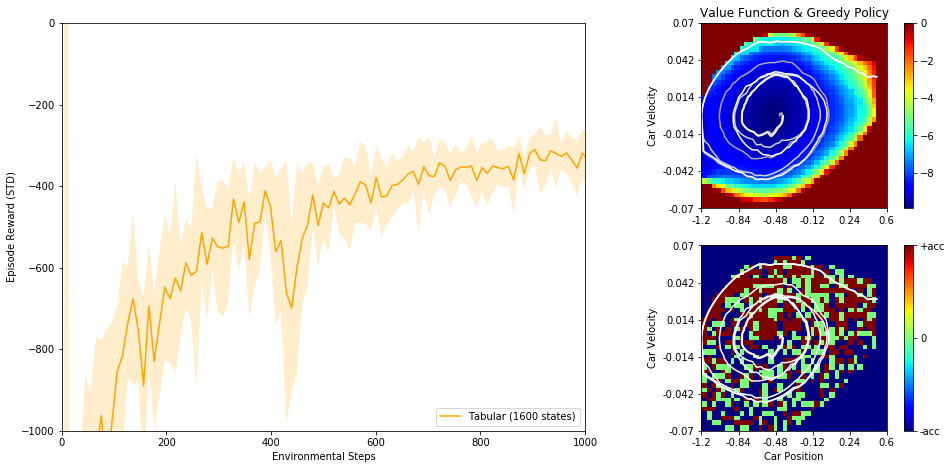

In [12]:
plot_all_results(results, env)

***Pros***

- Converges to a good policy on relatevely small state spaces
- Stable
- Intuitively easy to understand

***Cons***

- With the growth of the state space the Q-table grows also
- For much more complex task/environements the small discretization is not enough to capture all the features of the environment

# EXERCISE 2: Approximate Q-learning
In this exercise you will implement a QLearner based on gradient descend with a linear Q-value function.


## TASK 2a: basis functions
Now we want to use approximate Q-learning for linear functions. Familiarize yourself with our specification of basis functions.

We want to use some approximator to learn an action-value function $Q$:
$$\hat q(s,a,\theta) \approx q_{*}(s,a) \space \text{or} \space q_{\pi}(s,a)$$

Consider the objective function:
$$L(\theta) = \alpha(R_{t+1} + \gamma \max_{a} \hat{q}(s_{t+1},a,\theta) - \hat{q}(s_t,a_t,\theta))^2 $$

The <b>semi-gradient</b> of this objective function will be:
$$\nabla \theta_t = \alpha(R_{t+1}+\gamma \max_{a} \hat{q}(s_{t+1},a,\theta) - \hat{q}(s_t,a_t,\theta))\frac{\partial \hat{q}(s_t, a_t, \theta_t)}{\partial \theta_t}$$

***One-hot picture/formula***

***RBF basis***

In [0]:
from rl2utils import BasisFunctions


In [0]:
class OneHot (BasisFunctions):
    """ one-hot encoding of 2d-spaces """
    n_states = None

    def __init__(self, env, n_states):
        """ Creates a one-hot encoding with n_states discrete intervals in each input dimension. """
        BasisFunctions.__init__(self, env)
        self.name = "OneHot"
        self.n_states = n_states
        self.num_features = n_states ** 2

    def __call__(self, state):
        """ Overrides the () operator and returns a one-hot encoding of the given state."""
        phi = np.zeros(self.num_features)
        index = np.floor((state - self._env_low) / self._env_dx * (self.n_states-1))
        phi[int(index[0] * self.n_states + index[1])] = 1
        return phi

In [0]:
class RBF (BasisFunctions):
    """ Exponential radial basis functions in 2d spaces."""
    normalize = True      # this flag normalizes the L_1 norm of the output vector to 1
    centers = None
    sigmas = None

    def __init__(self, env, n_bases):
        """ Creates a set of equidistant basis functions with n_bases functions in each input dimension. """
        BasisFunctions.__init__(self, env)
        self.name = "RBF"
        self.num_features = n_bases ** 2
        self._make_centers(n_bases)
    
    def _make_centers(self, n_bases):
        """ Initializes the centers of the RBF basis functions as an equidistant grid 
            and width sigma as the distance between the centers to guarantee enough overlap. """
        # Create centers of the RBF
        self.centers = np.zeros((2, n_bases ** 2))
        self.centers[0, :] = np.repeat(np.linspace(self._env_low[0], self._env_high[0], num=n_bases), n_bases)
        self.centers[1, :] = np.tile(np.linspace(self._env_low[1], self._env_high[1], num=n_bases), n_bases)
        # Create widths of the RBF
        self.sigmas = np.zeros((2, n_bases ** 2))
        self.sigmas[0, :] = np.repeat(np.ones(n_bases) * self._env_dx[0] / (n_bases-1), n_bases)
        self.sigmas[1, :] = np.tile(np.ones(n_bases)  * self._env_dx[1] / (n_bases-1), n_bases)

    def __call__(self, state):
        """ Overrides the () operator and returns the (normalised) RBF output for the given state."""
        # Compute the RBFs
        phi = np.exp(- np.sum(((self.centers - np.expand_dims(state, axis=1)) / self.sigmas) ** 2, axis=0))
        # Optionally normalize the RBF output to sum 1
        if self.normalize:
            phi /= np.sum(phi, axis=0)
        # Return feature(s)
        return phi

## Task 2b: semi-gradients 
Derive the semi-gradient of the quadratic Bellman-error of Q-learning at time $t$ (i.e. after observing s_t, a_t, r_t and s_{t+1}) for a linear Q-function. Let us write down both the loss function and the semi-gradient as a LaTeX formula:

Let $\phi(s) = (\phi_1(s), \phi_2(s) ... \phi_d(s))$ be our feature vector (defined by our basis function), so that


The Q-value function is given by $Q(s,a) = \vec w^{a} \!\!\cdot \vec \phi(s)$.
\begin{eqnarray*} 
    \mathcal{L}_t &=& {\textstyle\frac{1}{2}} \Big( r_t 
                            + \gamma \max_{a'}\!\big\{ Q(s_{t+1}, a') \big\} 
                            - Q(s_t, a_t) \Big)^2
                    \;=\; {\textstyle\frac{1}{2}} \Big( r_t 
                            + \gamma \max_{a'}\!\big\{\vec w^{a'} \!\!\cdot \vec \phi(s_{t+1}) \big\} 
                            - \vec w^{a_t} \!\!\cdot \vec \phi(s_t) \Big)^2
\\[2mm]
    \frac{\partial \mathcal{L}_t}{\partial \vec w^{a}}  &=& 
            \left\{ \begin{array}{ll}
                                \big( r_t 
                                  + \gamma \max_{a'}\!\big\{ Q(s_{t+1}, a') \big\} 
                                  - Q(s_t, a_t) \big) \; \vec \phi(s_t)
                            & \text{if }a = a_t \\
                            \vec 0  &\text{if }a \neq a_t 
            \end{array}\right.
\end{eqnarray*}

>[Shimon Whiteson lecture 2, p.7](https://github.com/mlss-skoltech/lectures/blob/master/reinforcement_learning/lecture2_fa-2.pdf)

## TASK 2c: linear Q-functions 
Implement the corresponding semi-gradient QLearner in the below skeleton. Make sure that, similarly to task 1a, the end of the episode (done=True) is handled correctly.

In [0]:
class LinearQLearner (QLearner):
    learn_rate = 0.1
    basis = None
    weights = None

    def __init__(self, env, basis: BasisFunctions):
        self.name = "Linear (%u %s)" % (basis.num_features, basis.name)
        self.basis = basis
        self.weights = np.stack([basis.new_weights() for _ in range(env.action_space.n)], axis=0)

    def q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        return self.weights.dot(self.basis(state))

    def sample(self, state):
        """ Returns an action the agent has chosen at the given state. """
        return np.argmax(self.q_values(state))

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        not_done = 0 if done else 1
        td_error = reward + not_done * self.gamma * np.max(self.q_values(next_state)) - self.q_values(state)[action]
        self.weights[action, :] = self.weights[action, :] + self.learn_rate * td_error * self.basis(state)

## TASK 2d: approximation with one-hot bases 
Test your above implementation with one-hot basis functions (with 40 bases in each state-dimension). 

In [17]:
results.append(run_experiment(env, LinearQLearner(env, OneHot(env, 40))))

----- Start Learning with Linear (1600 OneHot) Q-learning -----
Episode #50 (142201 steps) -- Total reward = -1373, epsilon=0.1.
Episode #150 (237522 steps) -- Total reward = -591, epsilon=0.1.
Episode #250 (303459 steps) -- Total reward = -523, epsilon=0.1.
Episode #350 (359453 steps) -- Total reward = -527, epsilon=0.1.
Episode #450 (411318 steps) -- Total reward = -506, epsilon=0.1.
Episode #550 (456547 steps) -- Total reward = -408, epsilon=0.1.
Episode #650 (497551 steps) -- Total reward = -324, epsilon=0.1.
Episode #750 (539812 steps) -- Total reward = -959, epsilon=0.1.
Episode #850 (579910 steps) -- Total reward = -407, epsilon=0.1.
Episode #950 (614201 steps) -- Total reward = -393, epsilon=0.1.


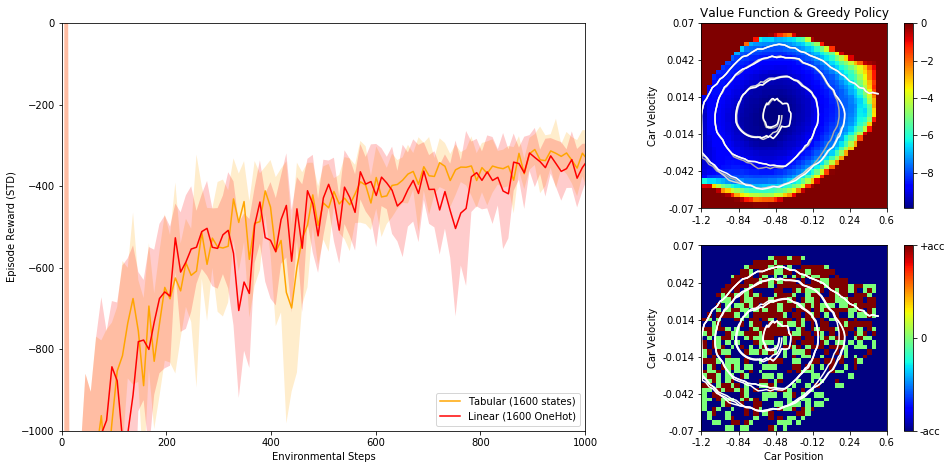

In [19]:
plot_all_results(results, env)

Gradient descent on one-hot vectors are equivalent to tabular Q-learning. Do your results mirror the performance of the TabularQLearner?

## Task 2e: approximation with RBF bases
Now test your LinearQLearner with the given RBF bases (15 centers for each state dimension). 

----- Start Learning with Linear (256 RBF) Q-learning -----
Episode #50 (58904 steps) -- Total reward = -490, epsilon=0.1.
Episode #150 (92304 steps) -- Total reward = -240, epsilon=0.1.
Episode #250 (113337 steps) -- Total reward = -169, epsilon=0.1.
Episode #350 (131344 steps) -- Total reward = -157, epsilon=0.1.
Episode #450 (148583 steps) -- Total reward = -152, epsilon=0.1.
Episode #550 (166008 steps) -- Total reward = -154, epsilon=0.1.
Episode #650 (183382 steps) -- Total reward = -152, epsilon=0.1.
Episode #750 (201968 steps) -- Total reward = -153, epsilon=0.1.
Episode #850 (218729 steps) -- Total reward = -158, epsilon=0.1.
Episode #950 (276887 steps) -- Total reward = -160, epsilon=0.1.


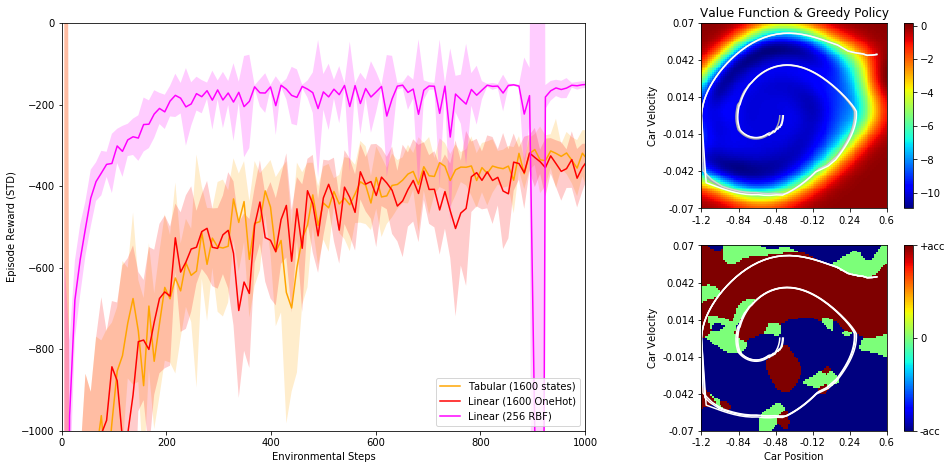

In [20]:
results.append(run_experiment(env, LinearQLearner(env, RBF(env, 16))))
plot_all_results(results, env)

Function approximation allows the agent to learn much faster, but the agent's performance can become extremly unstable in later episodes. This is somewhat surprising, as the lecture has established that semi-gradient TD(0) learning is supposed to converge in the linear case.

# EXERCISE 3: Stabilising Approximate Q-learning
Q-learning with semi-gradient descent is often unstable. In this exercise you will implement techniques that have emerged to stabilise approximate RL, namely Target Networks and Experience Replay Buffers.

## Task 3a: target networks
In this exercise you will improve the stability of gradient descend by using target networks. Note that for our purposes, the term "target network" refers to another weight vector. Extend the LinearQLearner with a target network, which is periodically updated with the current weights every 100 gradient steps.

In [0]:
class TargetQLearner (LinearQLearner):
    target_weights = None
    num_updates = 0
    update_target = 100

    def __init__(self, env, basis):
        LinearQLearner.__init__(self, env, basis)
        self.name = "Target (%u %s)" % (basis.num_features, basis.name)
        self.target_weights = self.weights.copy()

    def target_q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        return self.target_weights.dot(self.basis(state))

    def _refresh_target(self):
        """ Refresh the target network every update_target steps """
        self.num_updates += 1
        if self.num_updates % self.update_target == 0:
            self.target_weights = self.weights.copy()

    def update(self, state, action, reward, next_state, done):
        self._refresh_target()
        # Compute TD error
        not_done = 0 if done else 1
        td_error = reward + not_done*self.gamma*np.max(self.target_q_values(next_state)) \
                          - self.q_values(state)[action]
        # Gradient descend step
        self.weights[action, :] += self.learn_rate * td_error * self.basis(state)

Now test your above TargetQLearner with the same 16x16 RBF bases as above.

----- Start Learning with Target (256 RBF) Q-learning -----
Episode #50 (59321 steps) -- Total reward = -414, epsilon=0.1.
Episode #150 (93403 steps) -- Total reward = -240, epsilon=0.1.
Episode #250 (114584 steps) -- Total reward = -151, epsilon=0.1.
Episode #350 (131789 steps) -- Total reward = -148, epsilon=0.1.
Episode #450 (149053 steps) -- Total reward = -150, epsilon=0.1.
Episode #550 (168071 steps) -- Total reward = -150, epsilon=0.1.
Episode #650 (184863 steps) -- Total reward = -150, epsilon=0.1.
Episode #750 (202504 steps) -- Total reward = -151, epsilon=0.1.
Episode #850 (233905 steps) -- Total reward = -150, epsilon=0.1.
Episode #950 (249872 steps) -- Total reward = -156, epsilon=0.1.


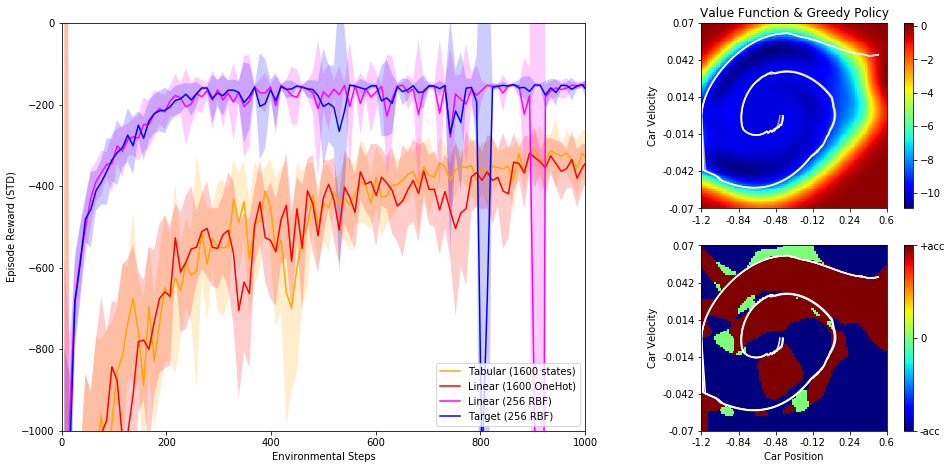

In [22]:
results.append(run_experiment(env, TargetQLearner(env, RBF(env, 16))))
plot_all_results(results, env)

The target networks can stabilise an agent's performance quite a bit, but do not have to. Do you observe more stable learning? Is the behaviour still unstable at the end?

## TASK 3b: double Q-learning
Extend the class TargetQLearner to implement double Q-learning (akin to Double DQN from the lecture).
>[Shimon Whiteson lecture 2, p. 28](https://github.com/mlss-skoltech/lectures/blob/master/reinforcement_learning/lecture2_fa-2.pdf)

Consider an MDP having four states two of which are terminal states.
State A is always considered at start state, and has two actions, either Right or Left. The Right action gives zero reward and lands in terminal state C.
The Left action moves the agent to state B with zero reward.

<img src='https://github.com/NinaMaz/mlss-tutorials/blob/master/whiteson/img/double_q.png?raw=1'>

State B has a number of actions, they move the agent to the terminal state D. However (this is important) the reward R of each action from B to D has a random value that follows a normal distribution with mean -0.5 and a variance 1.0.

<img src="https://github.com/NinaMaz/mlss-tutorials/blob/master/whiteson/img/double_q_alg.png?raw=1">

In [0]:
class DoubleQLearner (TargetQLearner):
    
    def __init__(self, env, basis):
        TargetQLearner.__init__(self, env, basis)
        self.name = "Double (%u %s)" % (basis.num_features, basis.name)

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        self._refresh_target()
        # Compute greedy actions at next_state with the current Q-function
        greedy = np.argmax(self.q_values(next_state)) #task
        # Compute TD-error with greedy actions for the target Q-function
        not_done = 0 if done else 1
        td_error = reward + not_done*self.gamma*self.target_q_values(next_state)[greedy] \
                          - self.q_values(state)[action]#task
        # Gradient descend step
        self.weights[action, :] += self.learn_rate * td_error * self.basis(state)

Now test your above DoubleQLearner with the same RBF bases as above. Double Q-learning should further stabilise the agent's performance. 

----- Start Learning with Double (256 RBF) Q-learning -----


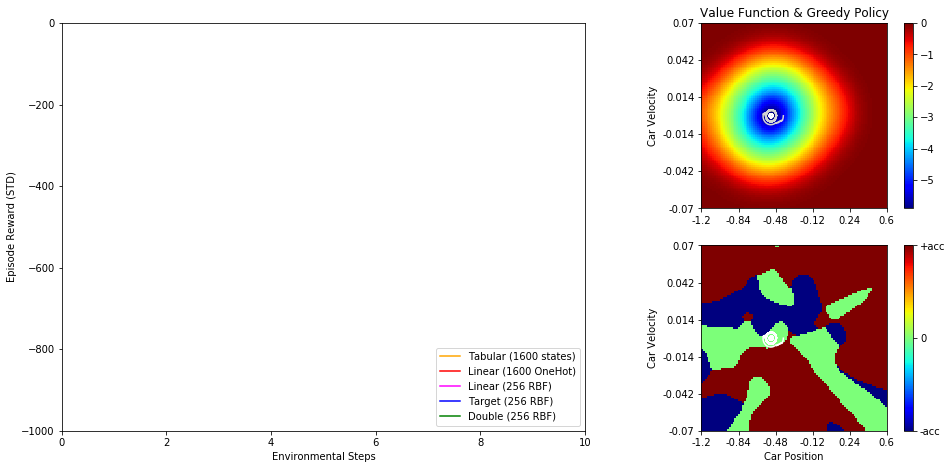

In [0]:
results.append(run_experiment(env, DoubleQLearner(env, RBF(env, 16))))
plot_all_results(results, env)

If you do not have a stable solution by now, increase the number of basis fuctions for each state dimension.
How does the policy look like in comparison to the tabular case in task 1c? Can you formulate an optimal policy for mountain-car based on your observations?

# EXERCISE 4: Deep Q-Networks
In this exercise we will implement Q-learning with a neural network. Read the DQN paper by Mnih et al. https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf for help with the exercise.

## TASK 4a
Implement a deep Q net that holds 10,000 transitions and uses a mini-batch of 32 samples. Make sure that the mini-batch always includes the newest transition.

The following code describes a simple replay buffer which is used to store (state, action, reward, next_state) tuples.

In [0]:
class Replay_buffer():
    def __init__(self, capacity):
        self.buffer = []
        for i in range(capacity):
                self.buffer.append(None)
        self.capacity = capacity
        self.insert_index = 0
        self.num_exp = 0

    def push(self, sarst):
        self.buffer[self.insert_index] = sarst
        self.insert_index = (self.insert_index + 1)%self.capacity
        if self.num_exp < self.capacity:
            self.num_exp += 1

    def sample_buffer(self):
        index = np.random.randint(self.num_exp-1)
        return self.buffer[index]

    def sample_batch(self, size):
        batch = []
        for i in range(size):
            batch.append(self.sample_buffer())
        return batch

Similarly the code-let below describes simple a 3 layer neural network which outputs an action value for all the valid actions in mountaincar.

In [0]:
class Value_Net(torch.nn.Module):
    hidden = 20
    
    def __init__(self):
        super(Value_Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, self.hidden)
        self.fc2 = torch.nn.Linear(self.hidden, self.hidden)
        self.fc3 = torch.nn.Linear(self.hidden, 3)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Use the previously defined classes for replay buffer and value network to implement your DQN.

In [0]:
class DQLearner(QLearner):
    buffer_size = 50000
    batch_size = 32
    learning_rate = 1e-4  # 1e-3

    def __init__(self):
        self.name = "DQN"
        self.epsilon = 1.0
        self.qnet = Value_Net()
        self.buffer = Replay_buffer(self.buffer_size)
        #self.optimizer = torch.optim.RMSprop(self.qnet.parameters(), lr=self.learning_rate)
        self.optimizer = torch.optim.RMSprop(self.qnet.parameters())
        self.criterion = torch.nn.MSELoss()

    def q_values(self, state):
        return self.qnet(torch.Tensor(state))

    def sample(self, state):
        return np.argmax(self.q_values(state).detach().numpy())

    def update(self, state, action, reward, next_state, done):
        obs = {'old': state, 'action': action, 'reward': reward, 'new': next_state, 'done': done}
        self.buffer.push(obs)
        if self.buffer.num_exp < self.batch_size:
            return
        else:
            batch = self.buffer.sample_batch(self.batch_size - 1)
            batch.append(obs)
            states = torch.Tensor(list(map(lambda x: x['old'], batch)))
            actions = torch.LongTensor(list(map(lambda x: x['action'], batch))).unsqueeze(1)
            rewards = torch.Tensor(list(map(lambda x: x['reward'], batch)))
            vals = self.qnet(states).gather(1, actions)
            vals = torch.squeeze(vals)
            targets = torch.zeros(self.batch_size)
            non_terminal_mask = torch.ByteTensor(list(map(lambda x: not x['done'], batch)))
            next_states_nont = torch.Tensor([s['new'] for s in batch if not s['done']])
            targets[non_terminal_mask] = self.qnet(next_states_nont).max(1)[0].detach()
            targets = targets * self.gamma + rewards
            self.optimizer.zero_grad()
            loss = self.criterion(vals, targets)
            loss.backward()
            self.optimizer.step()
            return
    
    def set_epsilon(self, iter):
        """ Exponentially decays the eploration parameter epsilon. """
        self.epsilon = nate**(-iter/250.0)

----- Start Learning with DQN Q-learning -----


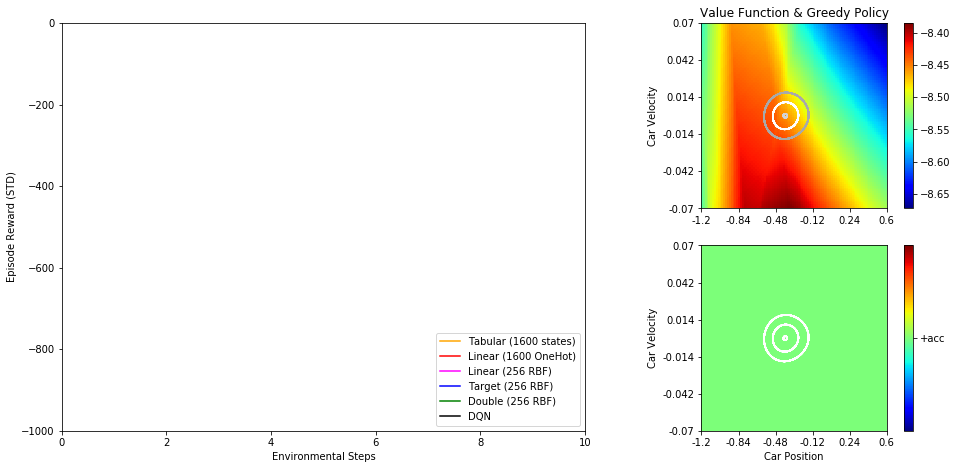

In [0]:
results.append(run_experiment(env, DQLearner()))
plot_all_results(results, env)

# EXERCISE 5: Improve Q-learning
If you have finished the above tasks and still have some time left, play aound with your solutions to improve performance. In particular, test the following changes for any of the above classes that inherit from LinearQLearner:

## TASK 5a: number of basis function
Plot the performance of the LinearQLearner (and it's descendants) against the number of used RBF basis functions in [10x10, ..., 20x20]. Does an increasing number of bases increase or decrease stability? Note that you need to write your own plotting script.

## TASK 5b: learning rate
Change the implementation of LinearQLearner (and it's descendants) to decrease the learning rate slowly. How does this change affect learning rate and stability? 

## TASK 5c: exploration
The experiment defined in task 1b uses epsilon-greedy exploration with a constant epsilon=0.1. Override the set_epsilon method of (a subclass of) LinearQLearner to implement a decay shedule, which decreases epsilon linearly from 1 to 0.01 in {10, 50, 100, 500} epsiodes. Does this improve the performance or not? What happens with an exponential decay schedule as in DQLearner?

## TASK 5d: DQN variations
There are several things that can be tried out with the DQN. Figure out if using different learning rates, losses and network architecture (number of layers and connectivity) changes the network performance. You can even change the replay buffer implementation to define some heuristic to draw samples from. Explore if these modifications help.

## TASK 5e: scientific evaluation
The experiment defined in task 1b fixes the random seed to ensure reproducability of results. However, each algorithm can behave very different depending on the seed. Run one (or all) above experiment(s) with 10 random seeds (i.e. comment out the lines that set the seed to 0) and plot the mean and staqndard deviation of the received rewards. Note that you may want to write your own plotting script, in which the shaded area refers to another type of standard deviation (between seeds, not over time) than in the given script.

## [cut?] TASK 3c: experience replay buffers
In this exercise you will further stabilize gradient descent by introducing an experience replay buffer.
Extend the above TargetQLearner with an experience replay buffer, that holds 10,000 transitions and uses a mini-batch of 32 samples. Make sure that the mini-batch always includes the newest transition.

In [0]:
class ReplayQLearner(DoubleQLearner):
    buffer_size = 20000
    mini_batch = 32
    buffer = None

    def __init__(self, env, basis):
        super().__init__(env, basis)
        self.name = "Replay (%u %s)" % (basis.num_features, basis.name)
        self.buffer = []
        # Adjust inherited parameters to work with the higher update rate
        self.learn_rate = self.learn_rate / self.mini_batch
        self.update_target = self.update_target * self.mini_batch

    def insert(self, state, action, reward, next_state, done):
        # Insert the observed transition into the replay buffer
        self.buffer.append((state, action, reward, next_state, done))
        # Always add (at least) the observed transition to the mini-batch
        batch = [(state, action, reward, next_state, done)]
        # Add mini_batch-1 randomly drawn past transitions to the mini-batch
        for _ in range(min(self.mini_batch, len(self.buffer)) - 1):
            # Draw a random transition from the last buffer_size entries of the replay buffer
            i = np.random.randint(max(0, len(self.buffer) - self.buffer_size), len(self.buffer))
            batch.append(self.buffer[i])
        return batch

    def update(self, state, action, reward, next_state, done):
        batch = self.insert(state, action, reward, next_state, done)
        for (s, a, r, ns, d) in batch:
            super().update(s, a, r, ns, d)
            
    def set_epsilon(self, iter):
        """ Maybe we must be random until the buffer is full? """
        self.epsilon = nate**(-iter/250.0)

Now test your ReplayQLearner with the same RBF bases as above. 

*Hint:* depending on the implementation, this experiment may run much longer than those before.

----- Start Learning with Replay (256 RBF) Q-learning -----


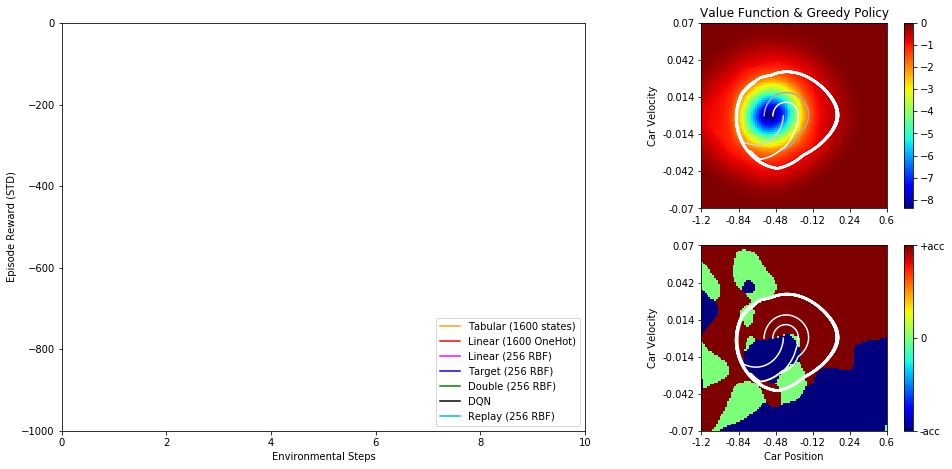

In [0]:
results.append(run_experiment(env, ReplayQLearner(env, RBF(env, 16))))
plot_all_results(results, env)